# I. Polynomial Regression, Step Functions, Splines (statsmodels)
# II. Splines (pyGAM)


Polynomial Regression and Step Functions is a python adaptation of p. 288-292 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani.

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline

/var/folders/29/wq14mrc56b72ty43ycw_32yr0000gn/T/ipykernel_53922/2971232441.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# 1. Polynomial Regression  

In this lab, we'll explore how to generate the `Wage` dataset models we saw in class.

In [5]:
df = pd.read_csv('Wage.csv')
df.head(3)

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


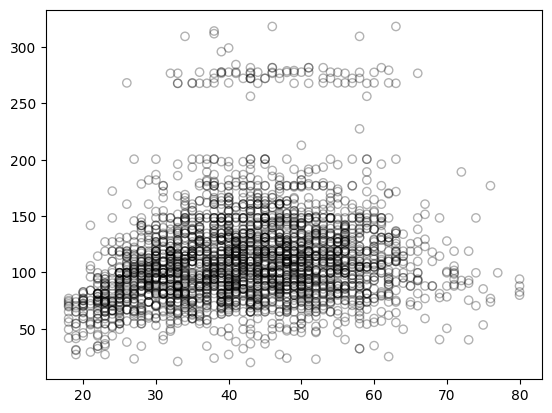

In [6]:
# Visualize the relationship b/w age and wage
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
plt.show()

We first fit the polynomial regression model using the following commands:

In [7]:
X1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.values.reshape(-1,1))

In [8]:
fit1 = sm.GLS(df.wage, X3).fit()
fit1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-75.2439,22.184,-3.392,0.001,-118.741,-31.747
x1,10.1900,1.605,6.348,0.000,7.043,13.337
x2,-0.1680,0.037,-4.559,0.000,-0.240,-0.096
x3,0.0008,0.000,3.143,0.002,0.000,0.001


This syntax fits a linear model, using the `PolynomialFeatures()` function, in order to predict
wage using up to a fourth-degree polynomial in `age`. The `PolynomialFeatures()` command
allows us to avoid having to write out a long formula with powers
of `age`. We can then fit our linear model:

In [9]:
fit2 = sm.GLS(df.wage, X4).fit() # sm.GLS:  Generalized Least Squares
fit2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


In [10]:
#Calculate the RMSE on the predictions (Train Error)
rms = sqrt(mean_squared_error(fit2.predict(X4), df.wage))
print(rms)

39.881508868256184


Next we consider the task of predicting whether an individual earns more
than \$250,000 per year. We proceed much as before, except that first we
create the appropriate response vector, and then we fit a logistic model using the `GLM()` function from `statsmodels`:

In [11]:
# Create response matrix 
y = (df.wage > 250).map({False:0, True:1}).to_numpy()

In [12]:
# Fit logistic model # sm.GLM: Generalized linear models
clf = sm.GLM(y, X4, family=sm.families.Binomial(link=sm.families.links.logit())) 
res = clf.fit() 

/Users/haoenhuang/Desktop/ML2/.venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


We now create a grid of values for `age` at which we want predictions, and
then call the generic `predict()` function for each model:

In [13]:
# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# Generate test data
X_test = PolynomialFeatures(4).fit_transform(age_grid)

# Predict the value of the generated ages
pred1 = fit2.predict(X_test) # salary
pred2 = res.predict(X_test)  # Pr(wage>250)

Finally, we plot the data and add the fit from the degree-4 polynomial.

Text(0, 0.5, 'Pr(wage>250|age)')

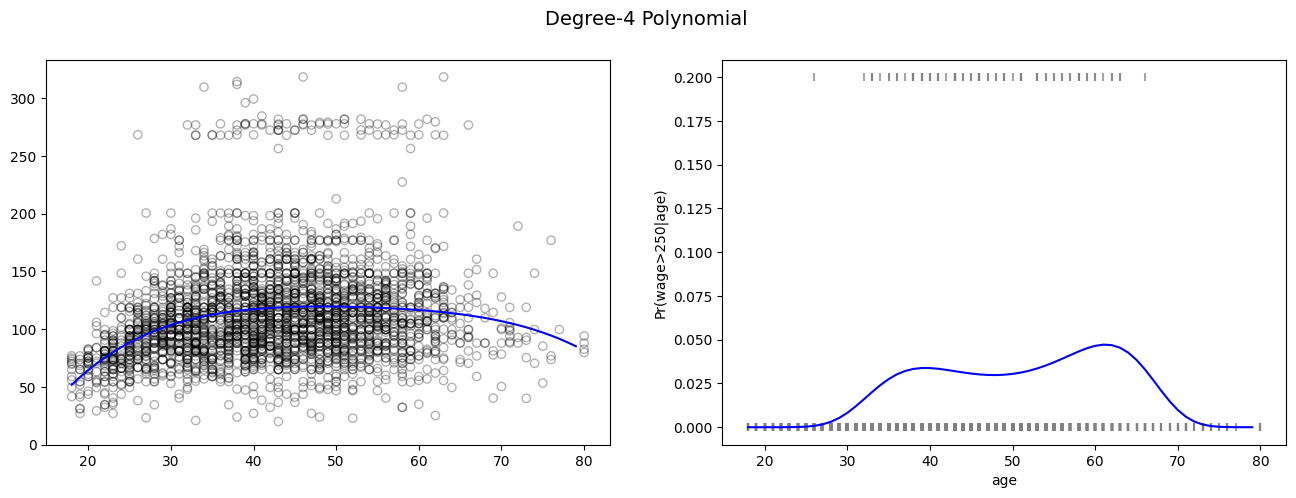

In [14]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
fig.suptitle('Degree-4 Polynomial', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, pred1, color = 'b')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(age_grid, pred2, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')

Several libraries provide polynomial fit functions: 1. numpy.polyfit (next) 2. sklearn.preprocessing import PolynomialFeatures(above). 

In [15]:
# Generating weights for polynomial function with degree =25
weights = np.polyfit(df.age, df.wage, 25)
print(weights) 

[-1.86832416e-37  7.59098517e-35 -1.03787200e-32  2.79747773e-31
  4.75795883e-29 -1.39000742e-27 -2.91746146e-25  1.12679168e-24
  1.75421387e-21  4.39442260e-20 -9.32471264e-18 -4.93073962e-16
  4.65910357e-14  3.51630723e-12 -2.65751599e-10 -1.82462400e-08
  1.92259296e-06  2.64056967e-05 -1.17358710e-02  8.11340074e-01
 -3.12269550e+01  7.72812406e+02 -1.26356808e+04  1.32700182e+05
 -8.14052220e+05  2.22266222e+06]


/var/folders/29/wq14mrc56b72ty43ycw_32yr0000gn/T/ipykernel_53922/296513700.py:2: RankWarning: Polyfit may be poorly conditioned
  weights = np.polyfit(df.age, df.wage, 25)


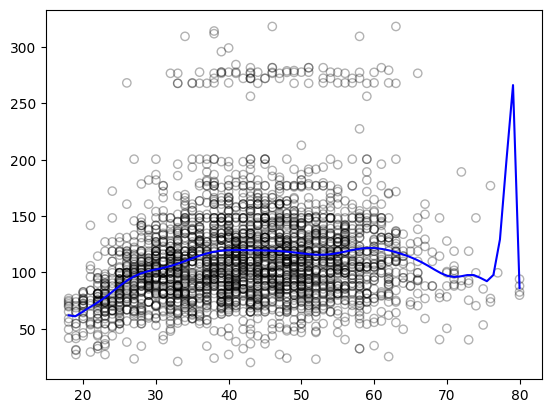

In [16]:
# Generating model with the given weights
model = np.poly1d(weights)

# Prediction on validation set
pred = model(df.age)
# We will plot the graph for 70 observations only
xp = np.linspace(df.age.min(),df.age.max(),70)
pred_plot = model(xp)
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot, color='blue')
plt.show()

# Deciding on a degree

In performing a polynomial regression we must decide on the degree of
the polynomial to use. One way to do this is by using hypothesis tests. We
now fit models ranging from linear to a degree-5 polynomial and seek to
determine the simplest model which is sufficient to explain the relationship
between `wage` and `age`.

We can do this using the `anova_lm()` function, which performs an
analysis of variance (ANOVA, using an F-test) in order to test the null
hypothesis that a model $M_1$ is sufficient to explain the data against the 
alternative hypothesis that a more complex model $M_2$ is required. In order
to use the `anova_lm()` function, $M_1$ and $M_2$ must be **nested models**: the
predictors in $M_1$ must be a subset of the predictors in $M_2$. In this case,
we fit five different models and sequentially compare the simpler model to
the more complex model (*Note:* you may get an *invalid value* Runtime Warning on the first model, because there is no "simpler model" to compare to):

In [17]:
fit_1 = fit = sm.GLS(df.wage, X1).fit()
fit_2 = fit = sm.GLS(df.wage, X2).fit()
fit_3 = fit = sm.GLS(df.wage, X3).fit()
fit_4 = fit = sm.GLS(df.wage, X4).fit()
fit_5 = fit = sm.GLS(df.wage, X5).fit()

print(sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1))

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


The $p$-value comparing the linear Model 1 to the quadratic Model 2 is
essentially zero $(<10^{-32})$, indicating that a linear fit is not sufficient. Similarly
the $p$-value comparing the quadratic Model 2 to the cubic Model 3
is very low (0.0017), so the quadratic fit is also insufficient. The $p$-value
comparing the cubic and degree-4 polynomials, Model 3 and Model 4, is approximately
0.05 while the degree-5 polynomial Model 5 seems unnecessary
because its $p$-value is 0.37. Hence, either a cubic or a quartic polynomial
appear to provide a reasonable fit to the data, but lower- or higher-order
models are not justified.

As an alternative to using hypothesis tests and ANOVA, we could choose
the polynomial degree using cross-validation as we have in previous labs.

# 2. Step functions
In order to fit a step function, we use the `cut()` function:

In [18]:
# Dividing the data into 4 bins
df_cut, bins = pd.cut(df.age, 4, retbins = True, right = True)
df_cut.value_counts(sort = False)

age
(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: count, dtype: int64

Here `cut()` automatically picked the cutpoints at 33.5, 49, and 64.5 years
of age. We could also have specified our own cutpoints directly. Now let's create a set of dummy variables for use in the regression:

In [19]:
df_steps = pd.concat([df.age, df_cut, df.wage], keys = ['age','age_cuts','wage'], axis = 1)

# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

# Drop the (17.938, 33.5] category
df_steps_dummies = df_steps_dummies.drop(df_steps_dummies.columns[1], axis = 1)

df_steps_dummies.head(5)

,const,"(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1.0,False,False,False
1,1.0,False,False,False
2,1.0,True,False,False
3,1.0,True,False,False
4,1.0,False,True,False


In [20]:
df_steps_dummies = df_steps_dummies.astype(int)
df_steps_dummies.head(5)

,const,"(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1,0,0,0
1,1,0,0,0
2,1,1,0,0
3,1,1,0,0
4,1,0,1,0


An now to fit the models! We dropped the `age<33.5` category, so the intercept coefficient of
\$94,160 can be interpreted as the average salary for those under 33.5 years
of age. The other coefficients can be interpreted as the average additional
salary for those in the other age groups. 

In [21]:
fit3 = sm.GLM(df_steps.wage, df_steps_dummies).fit()
fit3.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.265,97.051
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.468,27.639
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.611,27.718
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.135,17.416


We can produce predictions
and plots just as we did in the case of the polynomial fit.

In [22]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)

# Get dummies, drop first dummy category, add constant
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis = 1))

X_test2 = X_test2.astype(int)

# Predict the value of the generated ages using the linear model
pred2 = fit3.predict(X_test2)

# And the logistic model
clf2 = sm.GLM(y, df_steps_dummies,
              family=sm.families.Binomial(link=sm.families.links.logit()))
res2 = clf2.fit()
pred3 = res2.predict(X_test2)

/Users/haoenhuang/Desktop/ML2/.venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [23]:
# Calculating RMSE
rms = sqrt(mean_squared_error(df.wage, fit3.predict(df_steps_dummies))) 
print(rms) 

40.39685399790627


Text(0, 0.5, 'Pr(wage>250|age)')

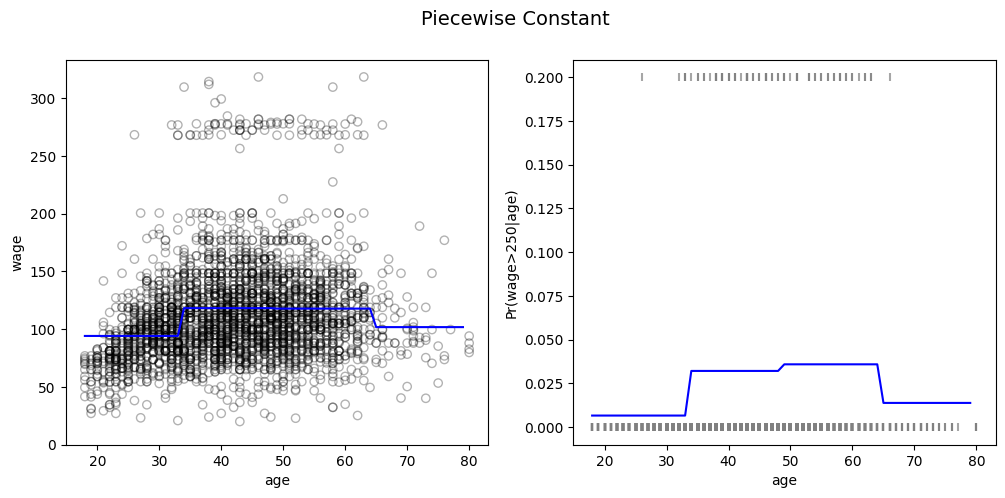

In [24]:
# Plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
fig.suptitle('Piecewise Constant', fontsize = 14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor = 'None', edgecolor = 'k', alpha = 0.3)
ax1.plot(age_grid, pred2, c = 'b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin = 0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred3, color = 'b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s = 30, c = 'grey', marker = '|', alpha = 0.7)

ax2.set_ylim(-0.01, 0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')

# 3. Splines (Using patsy -dmatrix)

In order to fit regression splines in python, we use the  ${\tt dmatrix}$ module from the <span style='color:Blue'> ${\tt patsy}$ </span>  library. In lecture, we saw that regression splines can be fit by constructing an appropriate matrix of basis functions. The ${\tt bs()}$ function generates the entire matrix of basis functions for splines with the specified set of knots.  

### B-Spline
Fitting ${\tt wage}$ to ${\tt age}$ using a regression spline is simple:

In [25]:
from patsy import dmatrix

# Specifying 3 knots
transformed_x1 = dmatrix("bs(df.age, knots=(25,40,60), degree=3, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')

# Build a regular linear model from the splines
fit1 = sm.GLM(df.wage, transformed_x1).fit()
fit1.params

Intercept                                                               60.493714
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.980500
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.630980
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.838788
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.990830
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.688098
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.606142
dtype: float64

In [26]:
transformed_x1

,Intercept,"bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]","bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]","bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]","bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]","bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]","bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]"
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1.0,0.559911,0.403778,0.033395,0.000000,0.000000,0.0
2,1.0,0.000000,0.114796,0.618564,0.262733,0.003906,0.0
3,1.0,0.000000,0.167109,0.633167,0.198880,0.000844,0.0
4,1.0,0.000000,0.034014,0.508194,0.426542,0.031250,0.0
...,...,...,...,...,...,...,...
2995,1.0,0.000000,0.139320,0.628472,0.230208,0.002000,0.0
2996,1.0,0.137741,0.629111,0.228819,0.004329,0.000000,0.0
2997,1.0,0.302617,0.586851,0.110255,0.000277,0.000000,0.0
2998,1.0,0.302617,0.586851,0.110255,0.000277,0.000000,0.0


Here we have prespecified knots at ages 25, 40, and 60. This produces a
spline with six basis functions. (Recall that a cubic spline with three knots
has seven degrees of freedom; these degrees of freedom are used up by an
intercept, plus six basis functions.) We could also use the ${\tt df}$ option to
produce a spline with knots at uniform quantiles of the data:

In [27]:
# Specifying 6 degrees of freedom 
transformed_x2 = dmatrix("bs(df.age, df=6, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')
fit2 = sm.GLM(df.wage, transformed_x2).fit()
fit2.params

Intercept                                       56.313841
bs(df.age, df=6, include_intercept=False)[0]    27.824002
bs(df.age, df=6, include_intercept=False)[1]    54.062546
bs(df.age, df=6, include_intercept=False)[2]    65.828391
bs(df.age, df=6, include_intercept=False)[3]    55.812734
bs(df.age, df=6, include_intercept=False)[4]    72.131473
bs(df.age, df=6, include_intercept=False)[5]    14.750876
dtype: float64

In this case python chooses knots which correspond
to the 25th, 50th, and 75th percentiles of ${\tt age}$. The function ${\tt bs()}$ also has
a ${\tt degree}$ argument, so we can fit splines of any degree, rather than the
default degree of 3 (which yields a cubic spline).


##  Natural cubic Spline (df=4)
In order to instead fit a natural spline, we use the ${\tt cr()}$ function. Here
we fit a natural spline with four degrees of freedom:

In [28]:
# Specifying 4 degrees of freedom
transformed_x3 = dmatrix("cr(df.age, df=4)", {"df.age": df.age}, return_type='dataframe')
fit3 = sm.GLM(df.wage, transformed_x3).fit()
fit3.params

Intercept              79.642095
cr(df.age, df=4)[0]   -14.667784
cr(df.age, df=4)[1]    36.811142
cr(df.age, df=4)[2]    35.934874
cr(df.age, df=4)[3]    21.563863
dtype: float64

As with the ${\tt bs()}$ function, we could instead specify the knots directly using
the ${\tt knots}$ option.

Let's see how these three models stack up:

Text(0, 0.5, 'wage')

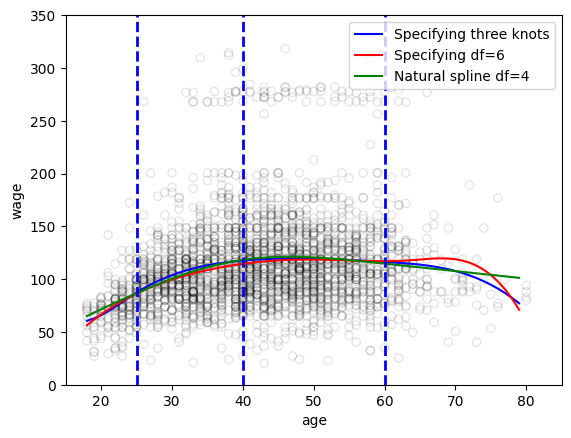

In [29]:
# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# Make some predictions
pred1 = fit1.predict(dmatrix("bs(age_grid, knots=(25,40,60), include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(age_grid, df=6, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
pred3 = fit3.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))

# Plot the splines and error bands
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred1, color='b', label='Specifying three knots')
plt.plot(age_grid, pred2, color='r', label='Specifying df=6')
plt.plot(age_grid, pred3, color='g', label='Natural spline df=4')
[plt.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [25,40,60]]
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')

# Other resources


1. Summary of Spline codes and libraries in several languages: https://bsplines.org/scientific-programming-with-b-splines/


2. ##### "SKlearn": 

- Generate univariate B-spline bases for features. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.SplineTransformer.html#sklearn.preprocessing.SplineTransformer 

- https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html#sphx-glr-auto-examples-linear-model-plot-polynomial-interpolation-py

- Time-related feature engineering Example: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py



3. Generative Additive Models with pyGAM: https://pygam.readthedocs.io/en/latest/ 


4. Smooting Splines using csaps: https://csaps.readthedocs.io/en/latest/


5. NaturalCubicSpline: https://github.com/madrury/basis-expansions 
With Python Examples:
https://github.com/madrury/basis-expansions/blob/master/examples/basis-expansion-regressions.ipynb 

# II. B-Spline by (pyGAM)

Recommend to study the tutorial: https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#

## 1. Classification by pyGAM

https://www.kaggle.com/datasets/abbasit/kyphosis-dataset


Let's get our (multivariate!) data, the kyphosis dataset, and the LogisticGAM model from pyGAM to do binary classification.

kyphosis - wherther a particular deformation was present post-operation
age - patient's age in months
number - the number of vertebrae involved in the operation
start - the number of the topmost vertebrae operated on

In [2]:
from pygam import LogisticGAM, s, f, l

In [30]:
kyphosis = pd.read_csv("kyphosis.csv")

display(kyphosis.head())
display(kyphosis.describe(include='all'))
display(kyphosis.dtypes)

,Kyphosis,Age,Number,Start
0,absent,71,3,5
1,absent,158,3,14
2,present,128,4,5
3,absent,2,5,1
4,absent,1,4,15


,Kyphosis,Age,Number,Start
count,81,81.000000,81.000000,81.000000
unique,2,NaN,NaN,NaN
top,absent,NaN,NaN,NaN
freq,64,NaN,NaN,NaN
mean,NaN,83.654321,4.049383,11.493827
std,NaN,58.104251,1.619423,4.883962
min,NaN,1.000000,2.000000,1.000000
25%,NaN,26.000000,3.000000,9.000000
50%,NaN,87.000000,4.000000,13.000000
75%,NaN,130.000000,5.000000,16.000000


Kyphosis    object
Age          int64
Number       int64
Start        int64
dtype: object

In [31]:
# convert the outcome in a binary form, 1 or 0
kyphosis = pd.read_csv("kyphosis.csv")
kyphosis["outcome"] = 1*(kyphosis["Kyphosis"] == "present")
kyphosis.describe()

,Age,Number,Start,outcome
count,81.000000,81.000000,81.000000,81.000000
mean,83.654321,4.049383,11.493827,0.209877
std,58.104251,1.619423,4.883962,0.409758
min,1.000000,2.000000,1.000000,0.000000
25%,26.000000,3.000000,9.000000,0.000000
50%,87.000000,4.000000,13.000000,0.000000
75%,130.000000,5.000000,16.000000,0.000000
max,206.000000,10.000000,18.000000,1.000000


In [32]:
X = kyphosis[["Age","Number","Start"]]
y = kyphosis["outcome"]

In [33]:
kyph_gam = LogisticGAM().fit(X,y)

In [29]:
kyph_gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     14.2822
Link Function:                        LogitLink Log Likelihood:                                   -18.4906
Number of Samples:                           81 AIC:                                               65.5456
                                                AICc:                                              73.2352
                                                UBRE:                                               2.9503
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.5557
Feature Function                  Lam

/var/folders/hy/v803x1q13cg8wy3k5zv615y80000gp/T/ipykernel_25462/3167408365.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  kyph_gam.summary()


In [34]:
kyph_gam.accuracy(X, y)

0.8888888888888888

#### Outcome dependence on features

One of the nice things about GAMs is that their additive nature allows us to explore and interpret individual features by holding others at their mean. The snippet of code below shows these plots for the features included in the trained model. generate_X_grid helps us build a grid for nice plotting.

To help us see how the outcome depends on each feature, pyGAM has the partial_dependence() function.

``pdep, confi = kyph_gam.partial_dependence(term=i, X=XX, width=0.95)``

For more on this see the : https://pygam.readthedocs.io/en/latest/api/logisticgam.html



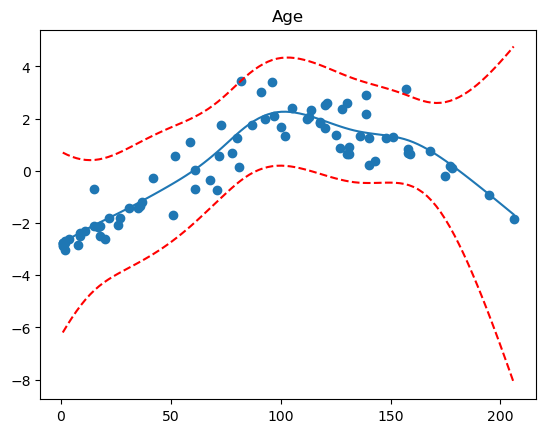

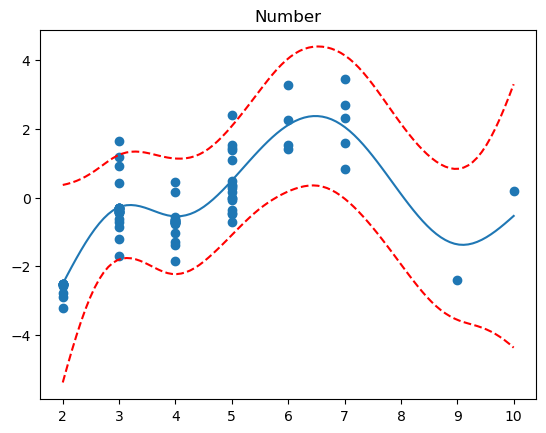

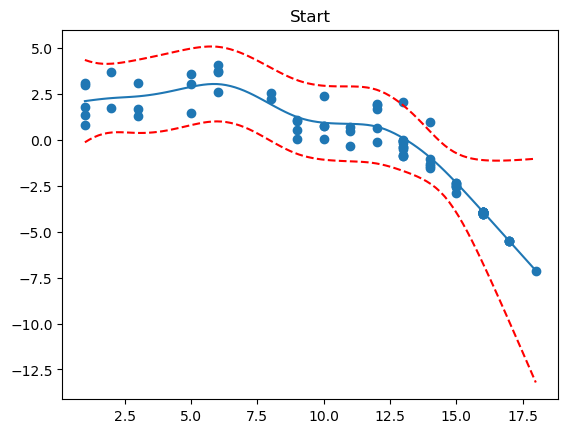

In [31]:
res = kyph_gam.deviance_residuals(X,y)
for i, term in enumerate(kyph_gam.terms):
    if term.isintercept:
        continue

    XX = kyph_gam.generate_X_grid(term=i)
    pdep, confi = kyph_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = kyph_gam.partial_dependence(term=i, X=X, width=0.95)
    plt.figure()
    plt.scatter(X.iloc[:,term.feature], pdep2 + res)
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X.columns.values[term.feature])
    plt.show()

### Specify basis functions

Notice that we did not specify the basis functions in the .fit(). pyGAM figures them out for us by using s()
 (splines) for numerical variables and f()
 for categorical features. If this is not what we want we can manually specify the basis functions, as follows:

In [32]:
kyph_gam = LogisticGAM(s(0)+s(1)+s(2)).fit(X,y)

/Users/he.wang/opt/anaconda3/envs/pyML/lib/python3.9/site-packages/pygam/pygam.py:593: RuntimeWarning: invalid value encountered in reciprocal
  weights ** -1)**-0.5)
/Users/he.wang/opt/anaconda3/envs/pyML/lib/python3.9/site-packages/pygam/pygam.py:752: RuntimeWarning: invalid value encountered in reciprocal
  np.fill_diagonal(Dinv, d**-1) # invert the singular values


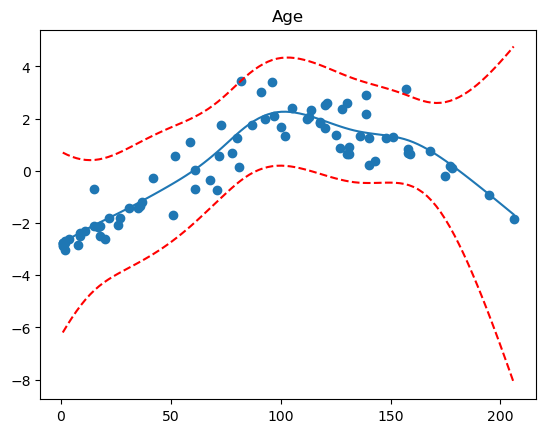

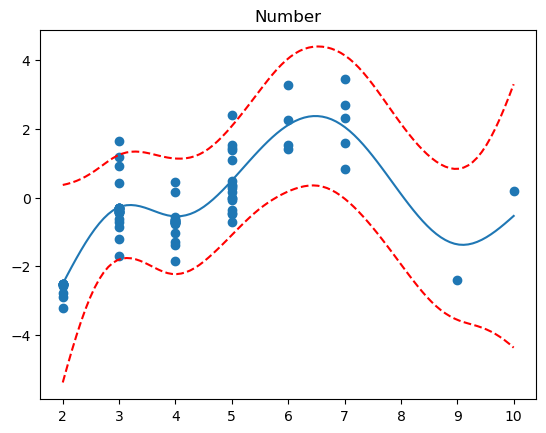

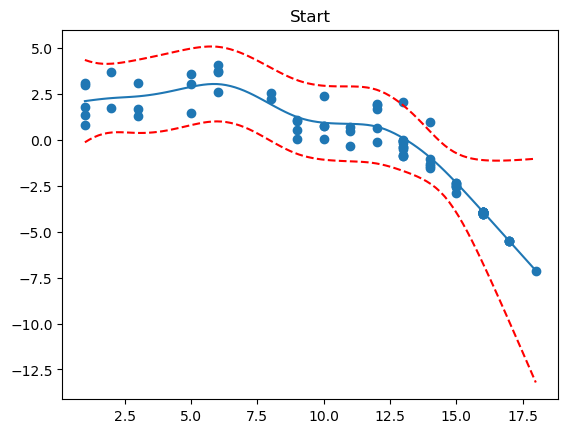

In [33]:
res = kyph_gam.deviance_residuals(X,y)
for i, term in enumerate(kyph_gam.terms):
    if term.isintercept:
        continue

    XX = kyph_gam.generate_X_grid(term=i)
    pdep, confi = kyph_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = kyph_gam.partial_dependence(term=i, X=X, width=0.95)
    plt.figure()
    plt.scatter(X.iloc[:,term.feature], pdep2 + res)
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X.columns.values[term.feature])
    plt.show()

In [34]:
kyph_gam.accuracy(X, y)

0.8888888888888888

### Tuning Smoothness and Penalties

In [35]:
lambda_ = 0.6
n_splines = [26, 26, 24] 
constraints = None
kyph_gam = LogisticGAM(constraints=constraints, 
          lam=lambda_,
         n_splines=n_splines).fit(X, y)

/Users/he.wang/opt/anaconda3/envs/pyML/lib/python3.9/site-packages/pygam/pygam.py:593: RuntimeWarning: invalid value encountered in reciprocal
  weights ** -1)**-0.5)
/Users/he.wang/opt/anaconda3/envs/pyML/lib/python3.9/site-packages/pygam/pygam.py:752: RuntimeWarning: invalid value encountered in reciprocal
  np.fill_diagonal(Dinv, d**-1) # invert the singular values


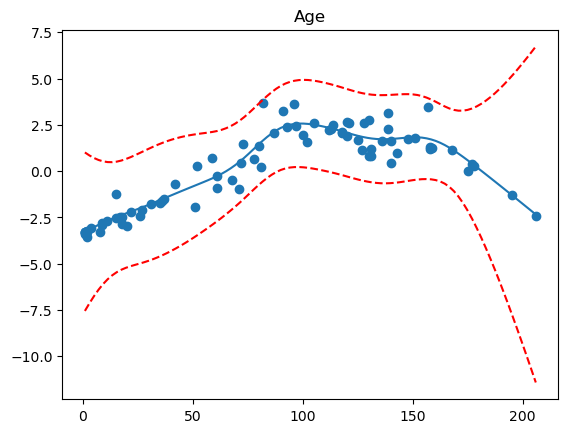

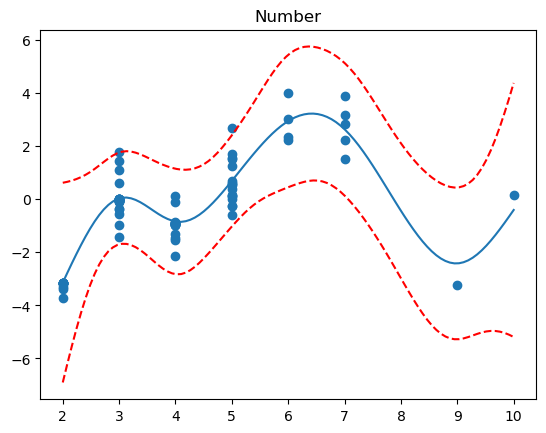

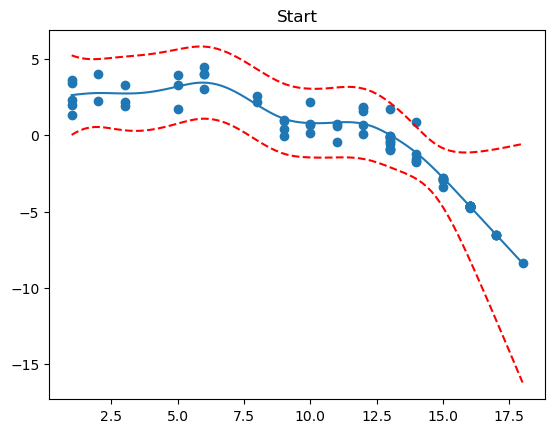

In [36]:
res = kyph_gam.deviance_residuals(X,y)
for i, term in enumerate(kyph_gam.terms):
    if term.isintercept:
        continue

    XX = kyph_gam.generate_X_grid(term=i)
    pdep, confi = kyph_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = kyph_gam.partial_dependence(term=i, X=X, width=0.95)
    plt.figure()
    plt.scatter(X.iloc[:,term.feature], pdep2 + res)
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X.columns.values[term.feature])
    plt.show()

In [37]:
kyph_gam.accuracy(X, y)

0.9135802469135802

Increase our training accuracy, but maybe it is overfitting

## 2. Regression in pyGAM

For regression problems, we can use a linearGAM model. For this part we will use the wages dataset.

https://pygam.readthedocs.io/en/latest/api/lineargam.html

In [38]:
# from the pyGAM documentation
from pygam import LinearGAM, s, f
from pygam.datasets import wage

X, y = wage(return_X_y=True)

### OLS regression using formulas

In [39]:
wage_df= pd.DataFrame({'year': X[:, 0], 'age': X[:, 1],'education': X[:, 2], 'wage': y})

In [40]:
import statsmodels.formula.api as sm

model1 = sm.ols('y ~ year +age+education',data=wage_df)
fit1_lm = model1.fit()

In [41]:
fit1_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     342.7
Date:                Sun, 12 Feb 2023   Prob (F-statistic):          2.45e-191
Time:                        16:17:01   Log-Likelihood:                -15007.
No. Observations:                3000   AIC:                         3.002e+04
Df Residuals:                    2996   BIC:                         3.005e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2126.9300    651.608     -3.264      0.001   -3404.574    -849.285
year           1.0878      0.325      3.348      0.001       0.451       1.725
age            0.5813      0.057     10.167      0.000       0.469       0.693
education     15.9157      0.543     29.337      0.000      14.852      16.979
==============================================================================
Omnibus:                     1013.276   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5153.652
Skew:                           1.530   Prob(JB):                         0.00
Kurtosis:                       8.645   Cond. No.                     1.99e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
wage_df.describe()

,year,age,education,wage
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,2005.791000,42.414667,2.010000,111.703608
std,2.026167,11.542406,1.215618,41.728595
min,2003.000000,18.000000,0.000000,20.085537
25%,2004.000000,33.750000,1.000000,85.383940
50%,2006.000000,42.000000,2.000000,104.921507
75%,2008.000000,51.000000,3.000000,128.680488
max,2009.000000,80.000000,4.000000,318.342430


In [43]:
x1_pred = np.linspace(2002,2009,100)
x2_pred = np.linspace(15,81,100)
x3_pred = np.linspace(0,5,100)


predict_df = pd.DataFrame({'year': x1_pred, 'age': x2_pred,'education': x3_pred})
predict_df.head()

,year,age,education
0,2002.000000,15.000000,0.000000
1,2002.070707,15.666667,0.050505
2,2002.141414,16.333333,0.101010
3,2002.212121,17.000000,0.151515
4,2002.282828,17.666667,0.202020


In [44]:
prediction_output = fit1_lm.get_prediction(predict_df).summary_frame()
prediction_output.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,59.653210,2.275880,55.190764,64.115656,-11.120018,130.426438
1,60.921477,2.228397,56.552134,65.290820,-9.845942,131.688896
2,62.189744,2.181028,57.913280,66.466208,-8.572001,132.951489
3,63.458011,2.133781,59.274187,67.641835,-7.298196,134.214218
4,64.726278,2.086665,60.634838,68.817718,-6.024526,135.477082


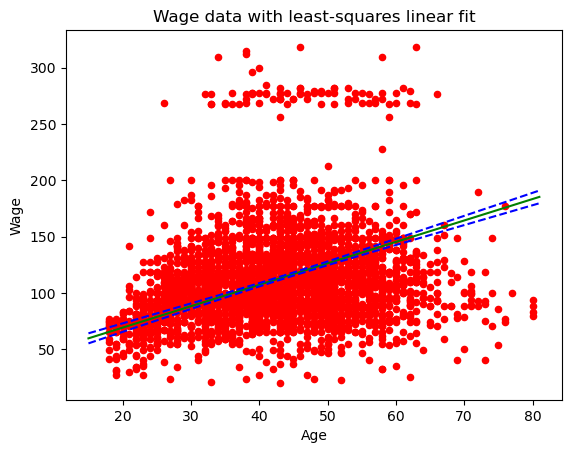

In [45]:
ax1 = wage_df.plot.scatter(x='age',y='wage',c='Red',title="Wage data with least-squares linear fit")
ax1.set_xlabel("Age")
ax1.set_ylabel("Wage")

ax1.plot(predict_df.age, prediction_output['mean'],color="green")
ax1.plot(predict_df.age, prediction_output['mean_ci_lower'], color="blue",linestyle="dashed")
ax1.plot(predict_df.age, prediction_output['mean_ci_upper'], color="blue",linestyle="dashed");

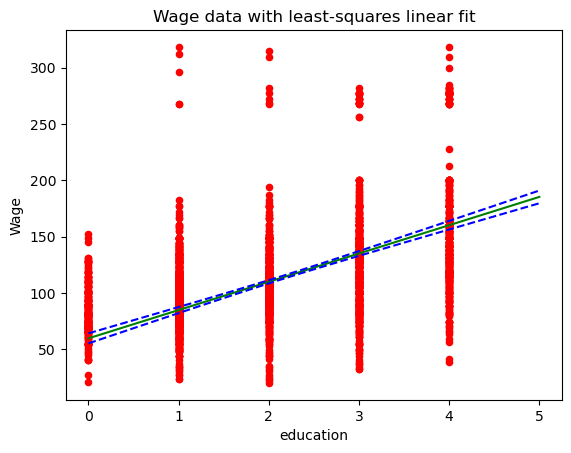

In [46]:
ax1 = wage_df.plot.scatter(x='education',y='wage',c='Red',title="Wage data with least-squares linear fit")
ax1.set_xlabel("education")
ax1.set_ylabel("Wage")

ax1.plot(predict_df.education, prediction_output['mean'],color="green")
ax1.plot(predict_df.education, prediction_output['mean_ci_lower'], color="blue",linestyle="dashed")
ax1.plot(predict_df.education, prediction_output['mean_ci_upper'], color="blue",linestyle="dashed");

### LinearGAM

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 640x480 with 0 Axes>

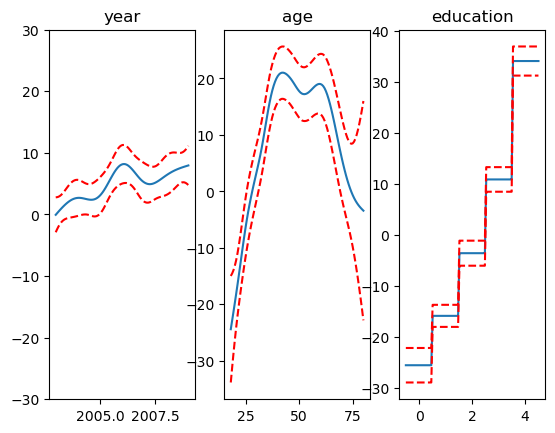

In [47]:
## model
gam = LinearGAM(s(0) + s(1) + f(2))
gam.gridsearch(X, y)


## plotting
plt.figure();
fig, axs = plt.subplots(1,3);

titles = ['year', 'age', 'education']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

### 3. Another Classification Example

In [48]:
import pandas as pd        
from pygam import LogisticGAM
from sklearn.datasets import load_breast_cancer
#load the breast cancer data set
data = load_breast_cancer()
#keep first 6 features only
df = pd.DataFrame(data.data, columns=data.feature_names)[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
target_df = pd.Series(data.target)
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400


In [49]:
X = df[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
y = target_df
#Fit a model with the default parameters
gam = LogisticGAM().fit(X, y)

/Users/he.wang/opt/anaconda3/envs/pyML/lib/python3.9/site-packages/pygam/pygam.py:593: RuntimeWarning: invalid value encountered in reciprocal
  weights ** -1)**-0.5)
/Users/he.wang/opt/anaconda3/envs/pyML/lib/python3.9/site-packages/pygam/pygam.py:752: RuntimeWarning: invalid value encountered in reciprocal
  np.fill_diagonal(Dinv, d**-1) # invert the singular values


In [50]:
gam.accuracy(X, y)

0.9560632688927944

In [51]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     19.4476
Link Function:                        LogitLink Log Likelihood:                                   -54.0256
Number of Samples:                          569 AIC:                                              146.9464
                                                AICc:                                             148.5483
                                                UBRE:                                               2.2856
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.8562
Feature Function                  Lam

/var/folders/hy/v803x1q13cg8wy3k5zv615y80000gp/T/ipykernel_25462/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


### Explore and interpret individual features

One of the nice things about GAMs is that their additive nature allows us to explore and interpret individual features by holding others at their mean. The snippet of code below shows these plots for the features included in the trained model. generate_X_grid helps us build a grid for nice plotting.

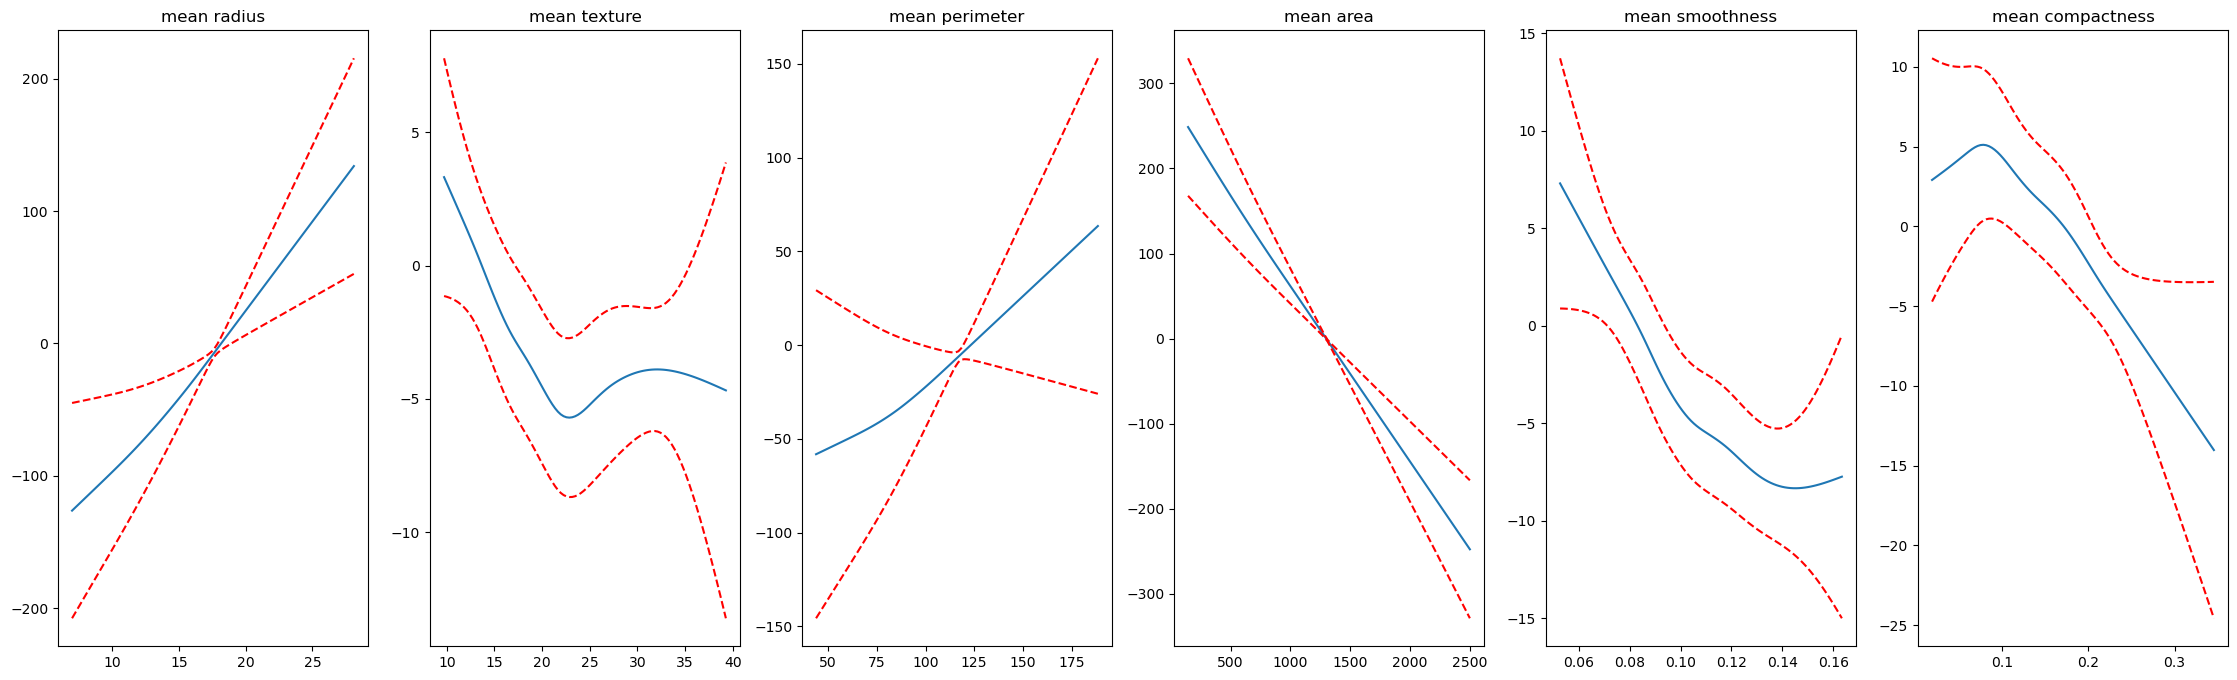

In [52]:
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, len(data.feature_names[0:6]))
titles = data.feature_names
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i) 
    pdep, confi = gam.partial_dependence(term=i, width=.95)
    
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--') 
    ax.set_title(titles[i])
plt.show()

In [53]:
gam.accuracy(X, y)

0.9560632688927944

### Tuning Smoothness and Penalties

In [54]:
lambda_ = 0.6
n_splines = [15, 17, 15, 30, 16, 15] 
constraints = None
gam = LogisticGAM(constraints=constraints, 
          lam=lambda_,
         n_splines=n_splines).fit(X, y)

/Users/he.wang/opt/anaconda3/envs/pyML/lib/python3.9/site-packages/pygam/pygam.py:593: RuntimeWarning: invalid value encountered in reciprocal
  weights ** -1)**-0.5)
/Users/he.wang/opt/anaconda3/envs/pyML/lib/python3.9/site-packages/pygam/pygam.py:752: RuntimeWarning: invalid value encountered in reciprocal
  np.fill_diagonal(Dinv, d**-1) # invert the singular values


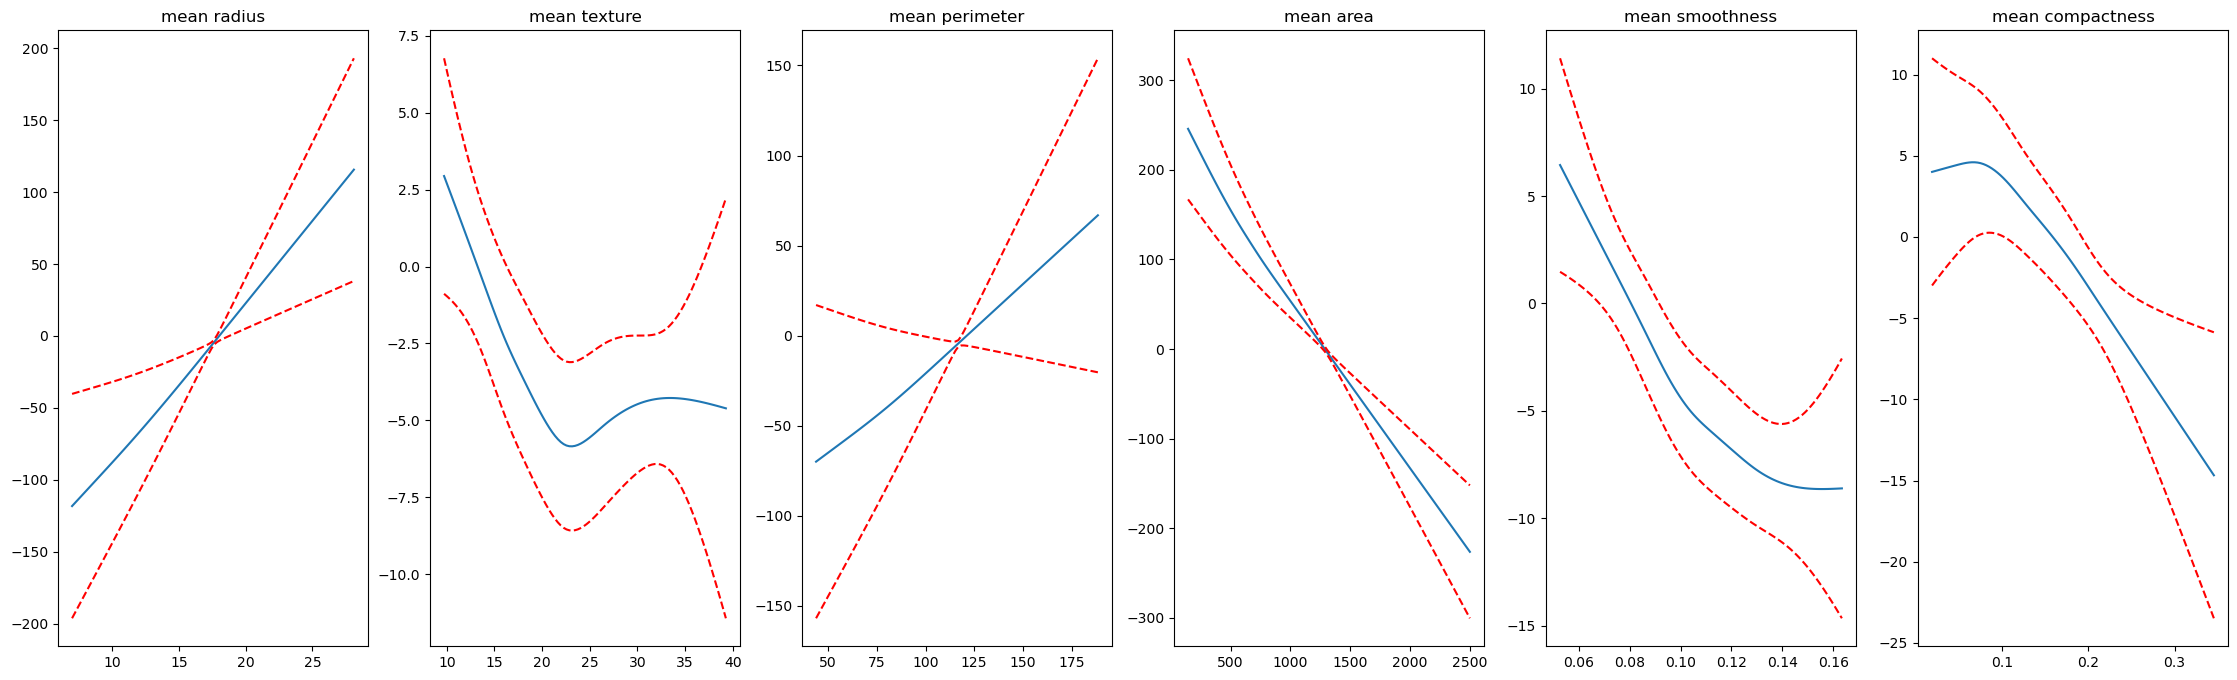

In [55]:
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, len(data.feature_names[0:6]))
titles = data.feature_names
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i) 
    pdep, confi = gam.partial_dependence(term=i, width=.95)
    
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--') 
    ax.set_title(titles[i])
plt.show()

In [56]:
gam.accuracy(X, y)

0.961335676625659